In [1]:
import sys
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
sys.path.append('../../')

import numpy as np
import random
from IPython.display import Image

import torch
from torch.utils.data import DataLoader

from torchvision.datasets.mnist import MNIST

from utils import show_first_batch, transform_data, show_images, plot_metrics_iddpm, show_tensor_images, calculate_metrics
from diffusion_models.ddpm_classifier_free_guidance import train_mnist
from metrics.fid_score import fid_score
from metrics.inception_score import inception_score


import ipywidgets as widgets
widgets.IntSlider()

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

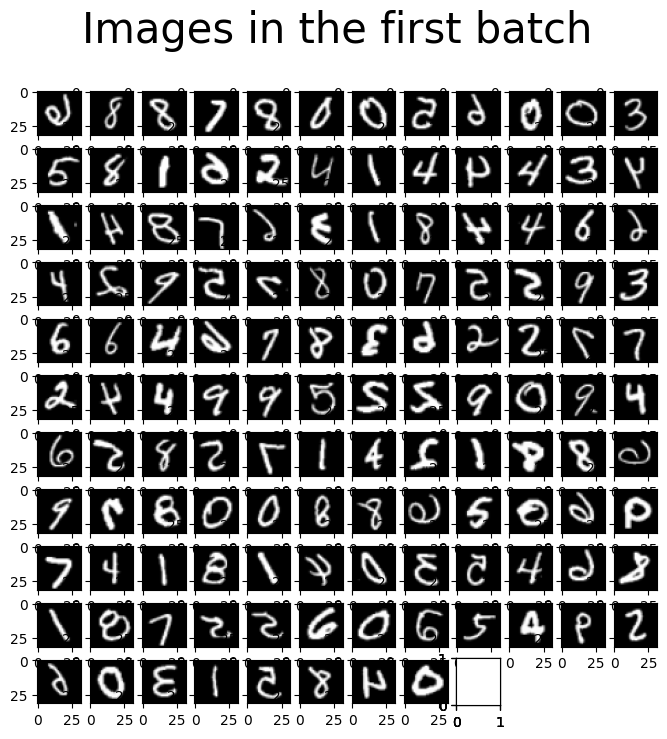

In [2]:
dataset = transform_data(MNIST, store_path="../../datasets")
train_dataloader = DataLoader(dataset, batch_size=128, num_workers=0, shuffle=True)
show_first_batch(train_dataloader)

In [ ]:
train_mnist()